In [11]:
#!pip install opencv-python
#!pip install tensorflow
#!pip install image-similarity-measures

import sys
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.utils as image
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre
from collections import Counter
import time
from datetime import datetime
import seaborn as sns
import pandas as pd

In [2]:
file_path = "test.zip"
output = file_path
if not os.path.exists("Test Set/"):
    gdown.download("https://drive.google.com/uc?id=1W94tVozlrHMY_SWE-45TvWT5PqQjElxc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [3]:
gender_img_height = 378
gender_img_width = 378
emotions_img_height = 224
emotions_img_width = 224
gender_class_names = ["Man", "Woman"]
emotions_class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [4]:
#Load the Model
file_path = "test.zip"
if not os.path.exists("Gender Model/"):
    gdown.download("https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
gender_model = keras.models.load_model('Gender Model/')

#Load the Model
file_path = "test.zip"
if not os.path.exists("Emotions Model/"):
    gdown.download("https://drive.google.com/uc?id=1zwwyyd0CZZBDOYt6vSliejyq7NrGbRsT", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
emotions_model = keras.models.load_model('Emotions Model/')

In [12]:
import warnings
warnings.filterwarnings("ignore")

def prepare_img(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    return images

def write_on_box(frame, gender, x, y, h, emotions):
    c = 10
    cv2.putText(frame, gender, (x, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    for key, value in emotions.items():    
        cv2.putText(
            frame, 
            str(key) + " " + str(value)[:-5], 
            (x, y-c), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9, 
            (36,255,12), 
            2
        )
        c += 30

def plotChart(emotions, gender, emotions_classes, live, history_dict):
    tmp_emotions_class_names = np.insert(emotions_class_names, 6, "")
    tmp_emotions_classes = np.insert(emotions_classes.flatten(), 6, 0)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(111, projection='polar')
    ax.set_xticklabels(tmp_emotions_class_names)
    theta = np.arange( 0, 2*np.pi, 2*np.pi/8)
    if bool(history_dict):
        for label in history_dict.keys():
            tmp = history_dict[label][-1]
            iterator = iter(tmp)
            next(iterator)
            key = next(iterator)
            i = np.where(tmp_emotions_class_names == key)[0][0]
            ax.scatter(theta[i], tmp[key], 100, label=label)
            ax.legend()
    else:
        key = next(iter(emotions))
        i = np.where(tmp_emotions_class_names == key)[0][0]
        ax.scatter(theta[i], tmp_emotions_classes[i], 100)
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    if live:
        cv2.imshow("chart", img)
        ax.set_visible(False)
        save_history(gender, emotions)

def save_history(gender, emotions):
    global history
    history = np.append(history, {"Gender": gender, **emotions})

def calc_closest_val(similarity, checkMax):
    result = {}

    if (checkMax):
        closest = max(similarity.values())
    else:
        closest = min(similarity.values())
    
    for key, value in similarity.items():
        if (value == closest):
            result[key] = closest
            
    return result

def find_gender(img):
    gender_classes = gender_classes_f(img)
    return gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]]

def find_emotions(img):
    tmp_dictionary = dict()
    emotions = dict()
    emotions_classes = emotions_classes_f(img)
    index = list(np.where(np.where(emotions_classes > 0, 1, 0)[0] == 1)[0])
    for i in index:
        tmp_dictionary[emotions_class_names[i]] = emotions_classes[0][i]
    sorted_keys = sorted(tmp_dictionary, key=tmp_dictionary.get, reverse=True)
    for k in sorted_keys:
        emotions[k] = tmp_dictionary[k]*100
    return emotions

def emotions_classes_f(img):
    emotions_img = cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width))
    return emotions_model.predict(prepare_img(emotions_img))

def gender_classes_f(img):
    gender_img = cv2.resize(np.float32(img), (gender_img_height, gender_img_width))
    return gender_model.predict(prepare_img(gender_img))

def calc_similarity(template_faces, face, dim):
    ssim_measures = dict()
    rmse_measures = dict()
    sre_measures = dict()
    for key in template_faces.keys():
        resized_img = cv2.resize(template_faces[key], dim, interpolation = cv2.INTER_AREA)
        ssim_measures[key]= ssim(face, resized_img)
        rmse_measures[key]= rmse(face, resized_img)
        sre_measures[key]= sre(face, resized_img)
    ssim_dict = calc_closest_val(ssim_measures, True)
    rmse_dict = calc_closest_val(rmse_measures, False)
    sre_dict = calc_closest_val(sre_measures, True)
    key1 = next(iter(ssim_dict))
    key2 = next(iter(rmse_dict))
    key3 = next(iter(sre_dict))

    if key1 == key2 or key1 == key3:
        if ssim_dict[key1] > 0.8:
            return key1
        else:
            return ""
    if key2 == key3:
        if sre_dict[key3] > 55:
            return key2
        else:
            return ""
    if key1 != key2 and key1 != key3 and key2 != key3:
        if ssim_dict[key1] > 0.8:
            return key1
        else:
            return ""

def new_person(template_faces, history_dict, faces_index, face, history):
    template_faces[f"Person{faces_index}"] = face
    history_dict[f"Person{faces_index}"] = history
    faces_index += 1
    return (template_faces, history_dict, faces_index)

def chart():
    for person in history_dict.keys():
        df = pd.DataFrame(history_dict[person].tolist())
        df = df.drop(columns="Gender")

        df.plot(kind='bar', stacked=False, figsize = (7,4))
        plt.legend(loc="center left", bbox_to_anchor=(1.0,0.5))
        plt.xticks(np.arange(len(df)), np.arange(1, len(df)+1), rotation=0)
        plt.xlabel("Time")
        plt.ylabel("Emotions Prediction")
        plt.savefig(f'chart of {person}.png', bbox_inches="tight")

1/1 [==============================] - 0s 104ms/step
Woman 'Happy': 99.99489188194275, 'Disgust': 96.43242359161377, 'Neutral': 94.32124495506287, 'Sad': 13.597330451011658, 'Angry': 6.749746948480606, 'Fear': 6.148917227983475, 'Surprise': 2.2391516715288162
1/1 [==============================] - 0s 44ms/step


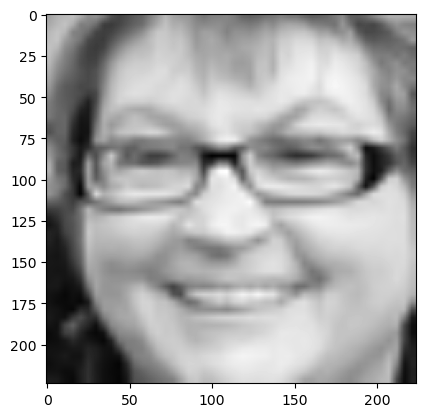

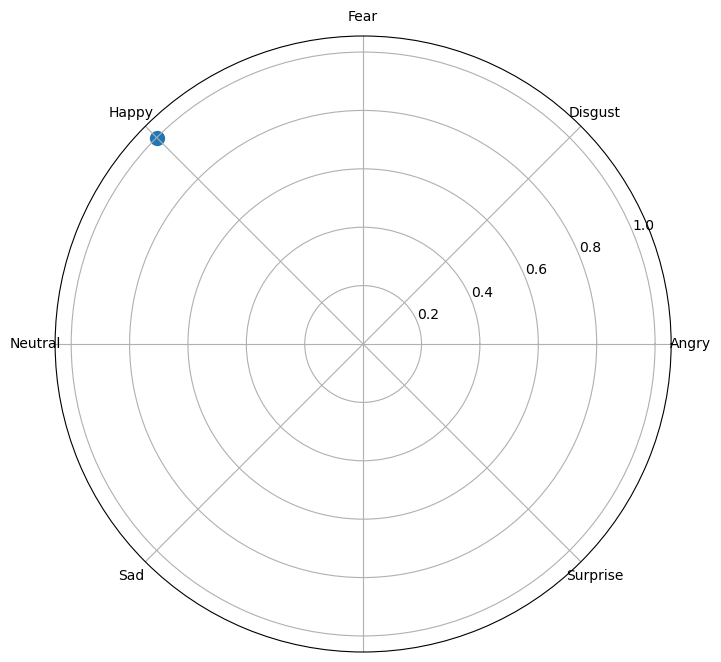

In [6]:
## Load and Predict an image
img = image.load_img("Test Set/Gender/Woman/100.png", color_mode = "grayscale")
face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')
faces = face_cascade.detectMultiScale(np.array(img))
for (x, y, w, h) in faces:
    gender = find_gender(np.array(img)[y:y+h, x:x+w])
    emotions = find_emotions(np.array(img)[y:y+h, x:x+w])

print(gender + " " + str(emotions)[1:-1])

plt.imshow(cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width)), cmap="gray")

plotChart(emotions, gender, emotions_classes_f(img), False, {})

In [7]:
cap = cv2.VideoCapture(0)
if not cap.isOpened(): 
    print("Unable to read camera feed")

fps = cap.get(cv2.CAP_PROP_FPS)
face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')

skip_frames = int(fps)/2
cur_frames = 0

template_faces = dict()
faces_index = 1
history_dict = dict()

while True:
    for i in range(1):
        cap.read()
    ret, frame = cap.read()
    if ret:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(frame)
        for (x, y, w, h) in faces:
            if w > 100 and h > 100:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (36,255,12), 2)
                if process_frame:
                    history = np.array([])
                    face = frame[y:y+h, x:x+w]
                    face_gray = gray[y:y+h, x:x+w]
                    dim = (int(face.shape[1]),int(face.shape[0]))

                    gender = find_gender(face_gray)
                    emotions = find_emotions(face_gray)

                    write_on_box(frame, gender, x, y, h, emotions)
                    plotChart(emotions, gender, emotions_classes_f(face_gray), True, history_dict)

                    if len(template_faces) > 0:
                        key = calc_similarity(template_faces, face, dim)
                        if key in history_dict:
                             history_dict[key] = np.append(history_dict[key], history)
                        else:
                            template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                    else:
                        template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                else:
                    write_on_box(frame, gender, x, y, h, emotions)
        cv2.imshow('frame', frame)
        cur_frames += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()
with open(f'Analysis {datetime.now().strftime("%H_%M_%S %d_%m_%Y")}.txt', 'w') as f:
    f.write(str(history_dict))


1/1 [==============================] - 0s 22ms/step
5.373501539230347


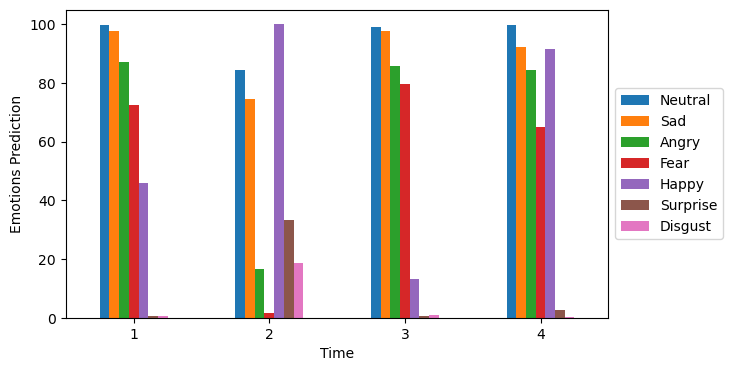

In [13]:
start = time.time()
cap = cv2.VideoCapture("test.mp4")

frame_width = int(cv2.CAP_PROP_FRAME_WIDTH)
frame_height = int(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)
skip = 3

out = cv2.VideoWriter('out.mp4', cv2.VideoWriter_fourcc(*'MP4V'), fps/skip, (frame_width,frame_height))

face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')

skip_frames = int(fps/skip)
cur_frames = 0

template_faces = dict()
faces_index = 1
history_dict = dict()

while True:
    for i in range(skip):
        cap.read()
    ret, frame = cap.read()
    if ret:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(frame)
        for (x, y, w, h) in faces:
            if w > 100 and h > 100:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (36,255,12), 2)
                if process_frame:
                    history = np.array([])
                    face = frame[y:y+h, x:x+w]
                    face_gray = gray[y:y+h, x:x+w]
                    dim = (int(face.shape[1]),int(face.shape[0]))
                    gender = find_gender(face_gray)
                    emotions = find_emotions(face_gray)
                    save_history(gender, emotions)
                    if len(template_faces) > 0:
                        key = calc_similarity(template_faces, face, dim)
                        if key in history_dict:
                            history_dict[key] = np.append(history_dict[key], history)
                        else:
                            template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                    else:
                        template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                else:
                    write_on_box(frame, gender, x, y, h, emotions)
        out.write(frame)
        cur_frames += 1
    else:
        break
out.release()
cv2.destroyAllWindows()
with open(f'Analysis {datetime.now().strftime("%H_%M_%S %d_%m_%Y")}.txt', 'w') as f:
    f.write(str(history_dict))
chart()
print(time.time() - start)

In [191]:
history_dict

{'Person1': array([{'Gender': 'Woman', 'Neutral': 0.9981836, 'Sad': 0.975776, 'Angry': 0.8723825, 'Fear': 0.7261701, 'Happy': 0.45934096, 'Surprise': 0.0063649276, 'Disgust': 0.005737464},
        {'Gender': 'Woman', 'Happy': 0.9997761, 'Neutral': 0.8441953, 'Sad': 0.74551976, 'Surprise': 0.33138922, 'Disgust': 0.18688323, 'Angry': 0.16688074, 'Fear': 0.016753735},
        {'Gender': 'Woman', 'Neutral': 0.9908241, 'Sad': 0.97885233, 'Angry': 0.8570204, 'Fear': 0.7976852, 'Happy': 0.13316894, 'Disgust': 0.009603931, 'Surprise': 0.0068588876},
        {'Gender': 'Woman', 'Neutral': 0.99880874, 'Sad': 0.92181474, 'Happy': 0.9167191, 'Angry': 0.8441368, 'Fear': 0.65031886, 'Surprise': 0.026606662, 'Disgust': 0.00079279253}],
       dtype=object)}